In [78]:
from time import sleep
from collections import namedtuple, deque
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import math
import random

from pettingzoo.classic import connect_four_v3

import pygame

In [79]:
# if GPU is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [80]:
#env = connect_four_v3.env(render_mode="human")
env = connect_four_v3.env()
env.reset()

In [81]:
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 0.001
TAU = 0.005
LR = 1e-4

In [82]:
# Get number of actions from gym action space
n_actions = 7

# Get the number of state observations
observation, reward, termination, truncation, info = env.last()

observation_shape = np.array(observation["observation"]).reshape(1,-1)
n_observations = 84



In [83]:
class ActorNetwork(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(ActorNetwork, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

In [84]:
class CriticNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(CriticNetwork, self).__init__()
        self.linear1 = nn.Linear(state_size, 128)
        self.linear2 = nn.Linear(128, 128)
        self.linear3 = nn.Linear(128, 1)

    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        return self.linear3(x)

In [85]:
class SAC:
    def __init__(self,lr,gamma, eps_start,eps_end,eps_dec, n_actions,action_space,policy_net,policy_optimizer,target_net,target_optimizer):
        
        self.lr = lr
        self.gamma = gamma
        self.epsilon = eps_start
        self.eps_end = eps_end
        self.eps_dec = eps_dec
        
        self.n_actions = n_actions
        self.action_space = action_space

        self.policy_net = policy_net
        self.policy_optimizer = policy_optimizer
        self.target_net = target_net
        self.target_optimizer = target_optimizer

        self.probs = []
        self.loss = 0

        self.Q = {}


    def choose_action(self, agent, state):
        if np.random.random() < self.epsilon:
            action = env.action_space(agent).sample(state["action_mask"])
            # action = np.random.choice(self.action_space)
        else:
            action_mask = torch.tensor(state["action_mask"])
            state_tensor = torch.FloatTensor(np.array(state["observation"]).reshape(1,-1))
            
            q_values = self.policy_net(state_tensor)
            max, min= torch.max(q_values), torch.min(q_values)
            q_values = (q_values-min)/ max
            valid_actions = action_mask *  q_values
            #print(valid_actions)
            self.probs = valid_actions

            action = np.argmax(valid_actions.detach().numpy())
            #print("q action: " + str(action))
            self.decrement_epsilon()
        return action
    
    def update(self, state,new_state):
        state_tensor = torch.FloatTensor(np.array(state["observation"]).reshape(1,-1))
        new_state_tensor = torch.FloatTensor(np.array(state["observation"]).reshape(1,-1))
        state_value_= self.target_net(state_tensor)
        new_state_value = self.target_net(new_state_tensor)




    
    def optimize(self):
        self.policy_optimizer.zero_grad()
        self.policy_optimizer.step()
        self.target_optimizer.zero_grad()
        self.target_optimizer.step()
    
    def decrement_epsilon(self):
        self.epsilon = self.epsilon - self.eps_dec \
            if self.epsilon > self.eps_end else self.eps_end
    
    def learn(self, state, action, reward, state_):

        state = state["observation"]
        state_ = state_["observation"]

        max_q_value = np.max(self.Q[state_, :])
        q_value = self.Q[state[0], state[1], action]
        self.Q[state[0], state[1], action] = q_value + self.lr * (reward + self.gamma * max_q_value - q_value)
    


In [86]:
policy_net = ActorNetwork(n_observations, n_actions).to(device)
target_net = CriticNetwork(n_observations, n_actions).to(device)
#target_net.load_state_dict(policy_net.state_dict())

Actor_optimizer = optim.Adam(policy_net.parameters(), lr=LR, amsgrad=True)
Critic_optimizer = optim.Adam(target_net.parameters(), lr=LR, amsgrad=True)


sac_agent = SAC(lr=LR,gamma=GAMMA,eps_start=EPS_START,
                eps_end=EPS_END,eps_dec=EPS_DECAY,
                n_actions=n_actions,action_space=n_observations,
                policy_net=policy_net,policy_optimizer=Actor_optimizer,
                target_net=target_net,target_optimizer=Critic_optimizer)


In [ ]:
memory = []

In [87]:
# Inicializa pygame
#pygame.init()

# Crea la ventana
#screen = pygame.display.set_mode ( (400,400),pygame.RESIZABLE )
#pygame.VIDEORESIZE

agent_score = []

num_episodes = 2000
total_reward_player_0 = 0
total_reward_player_1 = 0
last_action_player_1 = 0
previous_state = observation

for episode in range(num_episodes):


    state = env.reset()
    #env.render()
    


    for agent in env.agent_iter():
        #print(agent)
        state, reward, termination, truncation, info = env.last()


        if termination or truncation:
                print(env.rewards)
                total_reward_player_0 = total_reward_player_0 + env.rewards["player_0"]
                total_reward_player_1 = total_reward_player_1 + env.rewards["player_1"]
                sac_agent.optimize()
                agent_score.append(total_reward_player_1)
                #sac_agent.learn(previous_state,last_action_player_1,total_reward_player_1,state)

                break
        
        if(agent == "player_0"):
            #print("Player 1")

            mask = state["action_mask"]
            action = env.action_space(agent).sample(mask)  # this is where you would insert your policy
            #print(action)
            env.step(action)
        else:
            #print("Player 2")
            
            mask = state["action_mask"]
            #action = env.action_space(agent).sample(mask)  # this is where you would insert your policy
            action= sac_agent.choose_action(agent,state)

            #state_tensor = torch.FloatTensor(np.array(state["observation"]).reshape(1,-1))

            #action = policy_net.act(state_tensor)
            #print(action)
            #print(action)
            #action = int(input("Elige la columna: \n")) - 1 
            env.step(action) 

            new_state, new_reward, new_termination, new_truncation, new_info = env.last()
            


            last_action_player_1 = action 
        previous_state = state["observation"]
    env.close()

print("Total score player 1: " + str(total_reward_player_0))
print("Total score player 2: " + str(total_reward_player_1))


{'player_0': 1, 'player_1': -1}
{'player_0': -1, 'player_1': 1}
{'player_0': 1, 'player_1': -1}
{'player_0': -1, 'player_1': 1}
{'player_0': -1, 'player_1': 1}
{'player_0': -1, 'player_1': 1}
{'player_0': 1, 'player_1': -1}
{'player_0': 1, 'player_1': -1}
{'player_0': 1, 'player_1': -1}
{'player_0': 1, 'player_1': -1}
{'player_0': 1, 'player_1': -1}
{'player_0': -1, 'player_1': 1}
{'player_0': 1, 'player_1': -1}
{'player_0': 1, 'player_1': -1}
{'player_0': 1, 'player_1': -1}
{'player_0': -1, 'player_1': 1}
{'player_0': -1, 'player_1': 1}
{'player_0': -1, 'player_1': 1}
{'player_0': -1, 'player_1': 1}
{'player_0': -1, 'player_1': 1}
{'player_0': 1, 'player_1': -1}
{'player_0': 1, 'player_1': -1}
{'player_0': 1, 'player_1': -1}
{'player_0': 1, 'player_1': -1}
{'player_0': 1, 'player_1': -1}
{'player_0': -1, 'player_1': 1}
{'player_0': 1, 'player_1': -1}
{'player_0': 1, 'player_1': -1}
{'player_0': 1, 'player_1': -1}
{'player_0': 1, 'player_1': -1}
{'player_0': 1, 'player_1': -1}
{'player

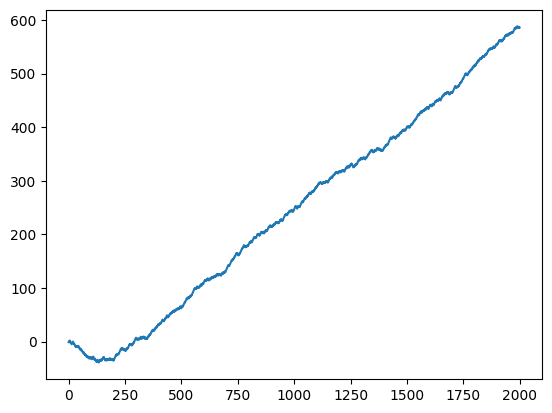

In [88]:
plt.plot(agent_score)
plt.show()

In [89]:
"""
Referencias:

https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html

"""

'\nReferencias:\n\nhttps://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html\n\n'

In [90]:
"""
class SAC(object):
    def __init__(self, num_inputs, action_space, args):

        self.gamma = args.gamma
        self.tau = args.tau
        self.alpha = args.alpha

        self.policy_type = args.policy
        self.target_update_interval = args.target_update_interval
        self.automatic_entropy_tuning = args.automatic_entropy_tuning

        self.device = torch.device("cuda" if args.cuda else "cpu")

        self.critic = QNetwork(num_inputs, action_space.shape[0], args.hidden_size).to(device=self.device)
        self.critic_optim = Adam(self.critic.parameters(), lr=args.lr)

        self.critic_target = QNetwork(num_inputs, action_space.shape[0], args.hidden_size).to(self.device)
        hard_update(self.critic_target, self.critic)

        if self.policy_type == "Gaussian":
            # Target Entropy = −dim(A) (e.g. , -6 for HalfCheetah-v2) as given in the paper
            if self.automatic_entropy_tuning is True:
                self.target_entropy = -torch.prod(torch.Tensor(action_space.shape).to(self.device)).item()
                self.log_alpha = torch.zeros(1, requires_grad=True, device=self.device)
                self.alpha_optim = Adam([self.log_alpha], lr=args.lr)

            self.policy = GaussianPolicy(num_inputs, action_space.shape[0], args.hidden_size, action_space).to(self.device)
            self.policy_optim = Adam(self.policy.parameters(), lr=args.lr)

        else:
            self.alpha = 0
            self.automatic_entropy_tuning = False
            self.policy = DeterministicPolicy(num_inputs, action_space.shape[0], args.hidden_size, action_space).to(self.device)
            self.policy_optim = Adam(self.policy.parameters(), lr=args.lr)

    def select_action(self, state, evaluate=False):
        state = torch.FloatTensor(state).to(self.device).unsqueeze(0)
        if evaluate is False:
            action, _, _ = self.policy.sample(state)
        else:
            _, _, action = self.policy.sample(state)
        return action.detach().cpu().numpy()[0]

    def update_parameters(self, memory, batch_size, updates):
        # Sample a batch from memory
        state_batch, action_batch, reward_batch, next_state_batch, mask_batch = memory.sample(batch_size=batch_size)

        state_batch = torch.FloatTensor(state_batch).to(self.device)
        next_state_batch = torch.FloatTensor(next_state_batch).to(self.device)
        action_batch = torch.FloatTensor(action_batch).to(self.device)
        reward_batch = torch.FloatTensor(reward_batch).to(self.device).unsqueeze(1)
        mask_batch = torch.FloatTensor(mask_batch).to(self.device).unsqueeze(1)

        with torch.no_grad():
            next_state_action, next_state_log_pi, _ = self.policy.sample(next_state_batch)
            qf1_next_target, qf2_next_target = self.critic_target(next_state_batch, next_state_action)
            min_qf_next_target = torch.min(qf1_next_target, qf2_next_target) - self.alpha * next_state_log_pi
            next_q_value = reward_batch + mask_batch * self.gamma * (min_qf_next_target)
        qf1, qf2 = self.critic(state_batch, action_batch)  # Two Q-functions to mitigate positive bias in the policy improvement step
        qf1_loss = F.mse_loss(qf1, next_q_value)  # JQ = 𝔼(st,at)~D[0.5(Q1(st,at) - r(st,at) - γ(𝔼st+1~p[V(st+1)]))^2]
        qf2_loss = F.mse_loss(qf2, next_q_value)  # JQ = 𝔼(st,at)~D[0.5(Q1(st,at) - r(st,at) - γ(𝔼st+1~p[V(st+1)]))^2]
        qf_loss = qf1_loss + qf2_loss

        self.critic_optim.zero_grad()
        qf_loss.backward()
        self.critic_optim.step()

        pi, log_pi, _ = self.policy.sample(state_batch)

        qf1_pi, qf2_pi = self.critic(state_batch, pi)
        min_qf_pi = torch.min(qf1_pi, qf2_pi)

        policy_loss = ((self.alpha * log_pi) - min_qf_pi).mean() # Jπ = 𝔼st∼D,εt∼N[α * logπ(f(εt;st)|st) − Q(st,f(εt;st))]

        self.policy_optim.zero_grad()
        policy_loss.backward()
        self.policy_optim.step()

        if self.automatic_entropy_tuning:
            alpha_loss = -(self.log_alpha * (log_pi + self.target_entropy).detach()).mean()

            self.alpha_optim.zero_grad()
            alpha_loss.backward()
            self.alpha_optim.step()

            self.alpha = self.log_alpha.exp()
            alpha_tlogs = self.alpha.clone() # For TensorboardX logs
        else:
            alpha_loss = torch.tensor(0.).to(self.device)
            alpha_tlogs = torch.tensor(self.alpha) # For TensorboardX logs


        if updates % self.target_update_interval == 0:
            soft_update(self.critic_target, self.critic, self.tau)

        return qf1_loss.item(), qf2_loss.item(), policy_loss.item(), alpha_loss.item(), alpha_tlogs.item()

    # Save model parameters
    def save_checkpoint(self, env_name, suffix="", ckpt_path=None):
        if not os.path.exists('checkpoints/'):
            os.makedirs('checkpoints/')
        if ckpt_path is None:
            ckpt_path = "checkpoints/sac_checkpoint_{}_{}".format(env_name, suffix)
        print('Saving models to {}'.format(ckpt_path))
        torch.save({'policy_state_dict': self.policy.state_dict(),
                    'critic_state_dict': self.critic.state_dict(),
                    'critic_target_state_dict': self.critic_target.state_dict(),
                    'critic_optimizer_state_dict': self.critic_optim.state_dict(),
                    'policy_optimizer_state_dict': self.policy_optim.state_dict()}, ckpt_path)

    # Load model parameters
    def load_checkpoint(self, ckpt_path, evaluate=False):
        print('Loading models from {}'.format(ckpt_path))
        if ckpt_path is not None:
            checkpoint = torch.load(ckpt_path)
            self.policy.load_state_dict(checkpoint['policy_state_dict'])
            self.critic.load_state_dict(checkpoint['critic_state_dict'])
            self.critic_target.load_state_dict(checkpoint['critic_target_state_dict'])
            self.critic_optim.load_state_dict(checkpoint['critic_optimizer_state_dict'])
            self.policy_optim.load_state_dict(checkpoint['policy_optimizer_state_dict'])

            if evaluate:
                self.policy.eval()
                self.critic.eval()
                self.critic_target.eval()
            else:
                self.policy.train()
                self.critic.train()
                self.critic_target.train()
"""

'\nclass SAC(object):\n    def __init__(self, num_inputs, action_space, args):\n\n        self.gamma = args.gamma\n        self.tau = args.tau\n        self.alpha = args.alpha\n\n        self.policy_type = args.policy\n        self.target_update_interval = args.target_update_interval\n        self.automatic_entropy_tuning = args.automatic_entropy_tuning\n\n        self.device = torch.device("cuda" if args.cuda else "cpu")\n\n        self.critic = QNetwork(num_inputs, action_space.shape[0], args.hidden_size).to(device=self.device)\n        self.critic_optim = Adam(self.critic.parameters(), lr=args.lr)\n\n        self.critic_target = QNetwork(num_inputs, action_space.shape[0], args.hidden_size).to(self.device)\n        hard_update(self.critic_target, self.critic)\n\n        if self.policy_type == "Gaussian":\n            # Target Entropy = −dim(A) (e.g. , -6 for HalfCheetah-v2) as given in the paper\n            if self.automatic_entropy_tuning is True:\n                self.target_entro